In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import os
from wordcloud import WordCloud

pd.set_option('display.max_colwidth', None)

In [2]:
clean_titles = pd.read_csv('../data/clean_titles.csv')

In [3]:
clean_titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   uniq_id     616 non-null    int64 
 1   Play        616 non-null    object
 2   Occurences  616 non-null    int64 
 3   Title       616 non-null    object
dtypes: int64(2), object(2)
memory usage: 19.4+ KB


In [4]:
clean_titles.sample(5)

,uniq_id,Play,Occurences,Title
271,647,midsummer nights dream,1,strange snow
265,640,midsummer nights dream,1,"the lunatic, the lover, and the poet"
345,904,tempest,1,prospero and ariel
602,404,multiple,3,to sleep no more
593,56,multiple,7,better days


In [5]:
print('Number of unique titles directly quoted from plays:', clean_titles.shape[0])
print('These titles comprise', clean_titles.Occurences.sum(), 'unique works')

Number of unique titles directly quoted from plays: 616
These titles comprise 1541 unique works


In [6]:
popular = clean_titles.nlargest(10, 'Occurences')
print('The 10 most popular titles are:')
for ind in popular.index:
    print(popular['Title'][ind], 'from', popular['Play'][ind], 'has been used', popular['Occurences'][ind], 'times')

The 10 most popular titles are:
full circle from king lear has been used 82 times
all that glitters from merchant of venice has been used 39 times
all our yesterdays from macbeth has been used 24 times
the quality of mercy from merchant of venice has been used 23 times
sweet revenge from othello has been used 19 times
outrageous fortune from hamlet has been used 17 times
perchance to dream from hamlet has been used 17 times
the evil that men do from julius caesar has been used 15 times
the seeds of time from macbeth has been used 14 times
midsummer madness from twelfth night has been used 14 times


In [7]:
unique = clean_titles[clean_titles['Occurences']== 1]
print('Number of titles that are unique:', unique.shape[0])

not_unique = clean_titles[clean_titles['Occurences']!= 1]
print('Number of titles that have been used more than once:', not_unique.shape[0])

Number of titles that are unique: 364
Number of titles that have been used more than once: 252


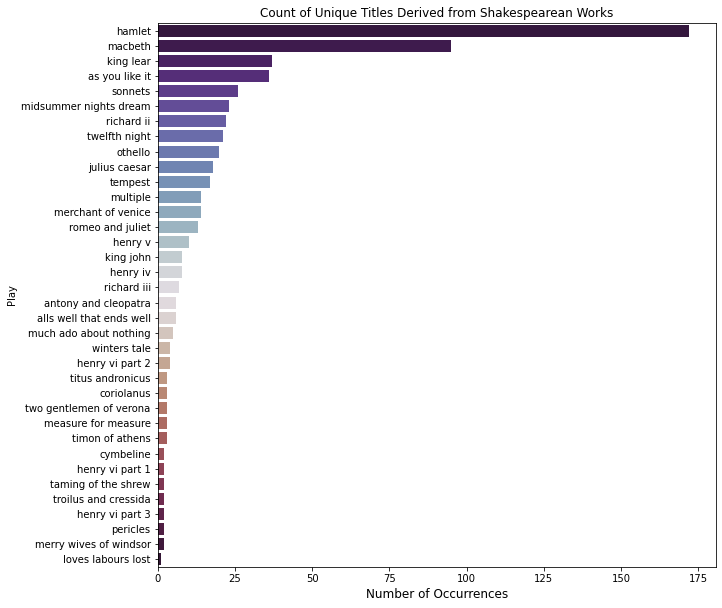

In [8]:
play_count = clean_titles.Play.value_counts()
plt.figure(figsize=(10,10))
sns.barplot(x=play_count.values, y=play_count.index, palette='twilight_shifted')
plt.title('Count of Unique Titles Derived from Shakespearean Works')
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('Play')
plt.show()

In [9]:
play_count = play_count.to_frame().reset_index().rename(columns={'index':'Play', 'Play':'Title_Count'})
play_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Play         36 non-null     object
 1   Title_Count  36 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 704.0+ bytes


There are many ways to rank the popularity of Shakespeare's plays; however, few of these are quantitative. I have chosen to rank his plays based on the data collected by Eric Minton at http://www.shakespeareances.com/wherewill/Play_Popularity_Index.html in which plays are ranked according to how frequently they are produced in live theaters in Australia, Canada, the UK, Denmark, and the US (between 2012 and May 2020). I've chosen to omit Sonnets from this ranking since they are not traditionally performed in the same way.

In [10]:
plays_ranked = pd.read_excel('../data/plays_ranked.xlsx', header=0)

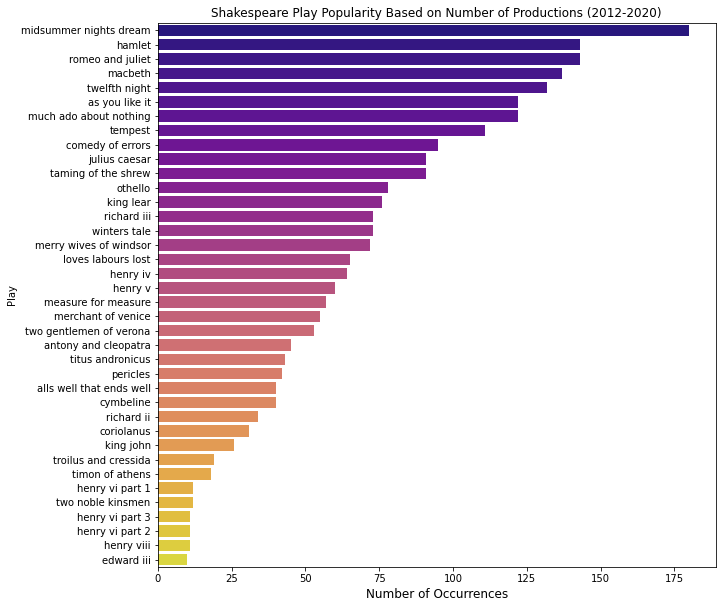

In [11]:
plt.figure(figsize=(10,10))
sns.barplot(x='Productions', y='Play', data=plays_ranked, palette='plasma')
plt.title('Shakespeare Play Popularity Based on Number of Productions (2012-2020)')
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('Play')
plt.show()

Combine the two informational dataframes

In [12]:
popularity = pd.merge(play_count, plays_ranked, on='Play', how='outer')

In [13]:
popularity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Play         40 non-null     object 
 1   Title_Count  36 non-null     float64
 2   Productions  38 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.2+ KB


In [14]:
popularity[popularity.Title_Count.isna()]

,Play,Title_Count,Productions
36,comedy of errors,NaN,95.0
37,two noble kinsmen,NaN,12.0
38,henry viii,NaN,11.0
39,edward iii,NaN,10.0


**NOTE** The dataset of Shakespeare's plays from Kaggle did not contain text from Two Noble Kinsmen or Edward III, and there were no titles taken from Henry VIII. Comedy of Errors produced one title ("Here's a Villain") that is also found in Henry VI, and was so re-catagorized as `Multiple`

In [15]:
popularity[popularity.Productions.isna()]

,Play,Title_Count,Productions
4,sonnets,26.0,NaN
11,multiple,14.0,NaN


In [16]:
popularity = popularity.dropna()
popularity.shape

(34, 3)

Add information about play types

In [17]:
play_cat_strict = {'comedy' : ['tempest',  'two gentlemen of verona',  'merry wives of windsor',  'measure for measure',  'comedy of errors',  'much ado about nothing',  'loves labours lost',  'midsummer nights dream',  'merchant of venice',  'as you like it',  'taming of the shrew',  'alls well that ends well',  'twelfth night',  'winters tale',  'pericles'], 'history' : ['king john',  'richard ii',  'henry iv', 'henry v',  'henry vi part 1',  'henry vi part 2',  'henry vi part 3',  'richard iii',  'henry viii'], 'tragedy' : ['troilus and cressida', 'coriolanus', 'titus andronicus',  'romeo and juliet',  'timon of athens',  'julius caesar',  'macbeth',  'hamlet',  'king lear',  'othello',  'antony and cleopatra',  'cymbeline']}
play_cat_modern = {'comedy' : ['two gentlemen of verona',  'merry wives of windsor',  'measure for measure',  'comedy of errors',  'much ado about nothing',  'loves labours lost',  'midsummer nights dream',  'merchant of venice',  'as you like it',  'taming of the shrew',  'alls well that ends well',  'twelfth night'], 'romance' : ['pericles',  'cymbeline',  'winters tale',  'tempest'],  'tragedy' : ['troilus and cressida', 'coriolanus', 'titus andronicus',  'romeo and juliet',  'timon of athens',  'julius caesar',  'macbeth',  'hamlet',  'king lear',  'othello',  'antony and cleopatra', 'king john',  'richard ii',  'henry iv',  'henry v',  'henry vi part 1',  'henry vi part 2',  'henry vi part 3',  'richard iii',  'henry viii']}

In [18]:
cat_plays = collections.OrderedDict()

for cat, plays in play_cat_strict.items():
    for i in range(len(plays)):
        cat_plays[plays[i]] = []
        cat_plays[plays[i]].append(cat)

for cat, plays in play_cat_modern.items():
    for i in range(len(plays)):
        cat_plays[plays[i]].append(cat)

In [19]:
cat_df = pd.DataFrame.from_dict(cat_plays, orient='index', columns=['Traditional', 'Modern']).reset_index()
cat_df = cat_df.rename(columns={'index':'Play'})

In [20]:
popularity = pd.merge(popularity, cat_df, on='Play', how='outer')
popularity.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 35
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Play         36 non-null     object 
 1   Title_Count  34 non-null     float64
 2   Productions  34 non-null     float64
 3   Traditional  36 non-null     object 
 4   Modern       36 non-null     object 
dtypes: float64(2), object(3)
memory usage: 1.7+ KB


In [21]:
popularity[popularity.Title_Count.isna()]

,Play,Title_Count,Productions,Traditional,Modern
34,comedy of errors,NaN,NaN,comedy,comedy
35,henry viii,NaN,NaN,history,tragedy


In [22]:
popularity = popularity.dropna()
popularity.shape

(34, 5)

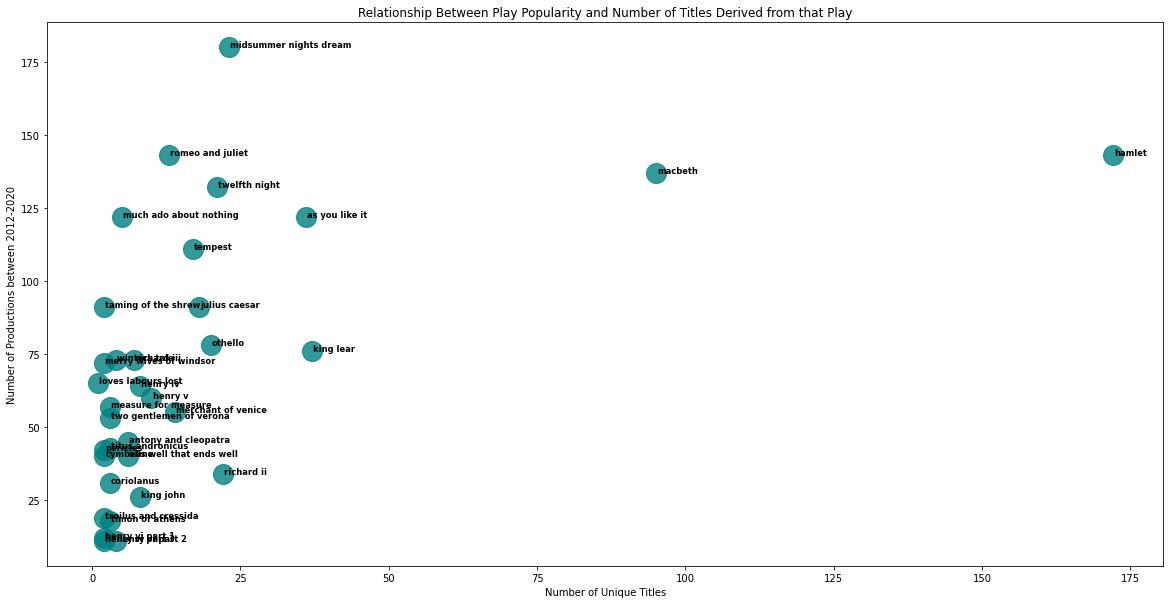

In [23]:
plt.figure(figsize=(20,10))
p1 = sns.regplot(x='Title_Count', y='Productions', data=popularity, fit_reg=False, marker='o', color='teal', scatter_kws={'s':400})
plt.xlabel('Number of Unique Titles')
plt.ylabel('Number of Productions between 2012-2020')
plt.title('Relationship Between Play Popularity and Number of Titles Derived from that Play')

for line in range(0, popularity.shape[0]):
     p1.text(popularity['Title_Count'][line]+0.2, popularity.Productions[line], popularity.Play[line], horizontalalignment='left', size='small', color='black', weight='semibold')
plt.show()        

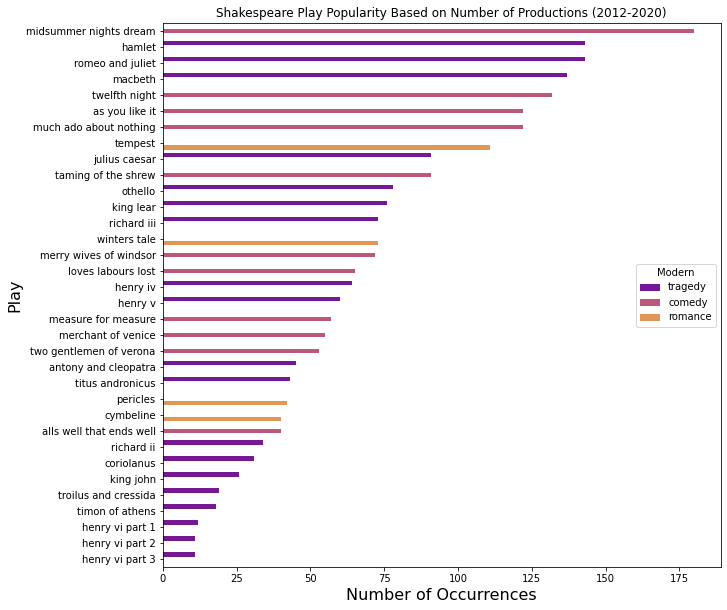

In [24]:
plt.figure(figsize=(10,10))
sns.barplot(x='Productions', y='Play', data=popularity, hue='Modern', palette='plasma', order=popularity.sort_values('Productions',ascending = False).Play)
plt.title('Shakespeare Play Popularity Based on Number of Productions (2012-2020)')
plt.xlabel('Number of Occurrences', fontsize=16)
plt.ylabel('Play', fontsize=16)
plt.show()

**NOTE** The uneven spacing between the bars is a known issue in seaborn and results from the way `hue` adds an additional layer of nesting to the bars. The community recommends using subplots or dotplots!

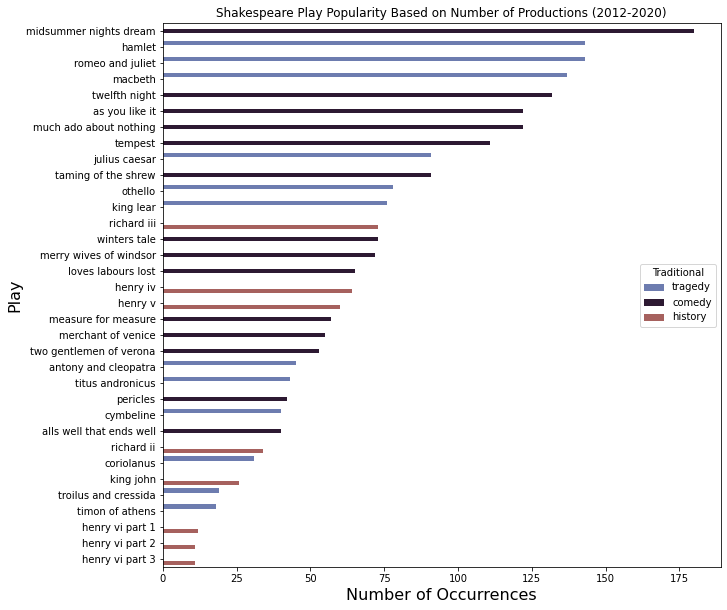

In [25]:
plt.figure(figsize=(10,10))
sns.barplot(x='Productions', y='Play', data=popularity, hue='Traditional', palette='twilight', order=popularity.sort_values('Productions',ascending = False).Play)
plt.title('Shakespeare Play Popularity Based on Number of Productions (2012-2020)')
plt.xlabel('Number of Occurrences', fontsize=16)
plt.ylabel('Play', fontsize=16)
plt.show()

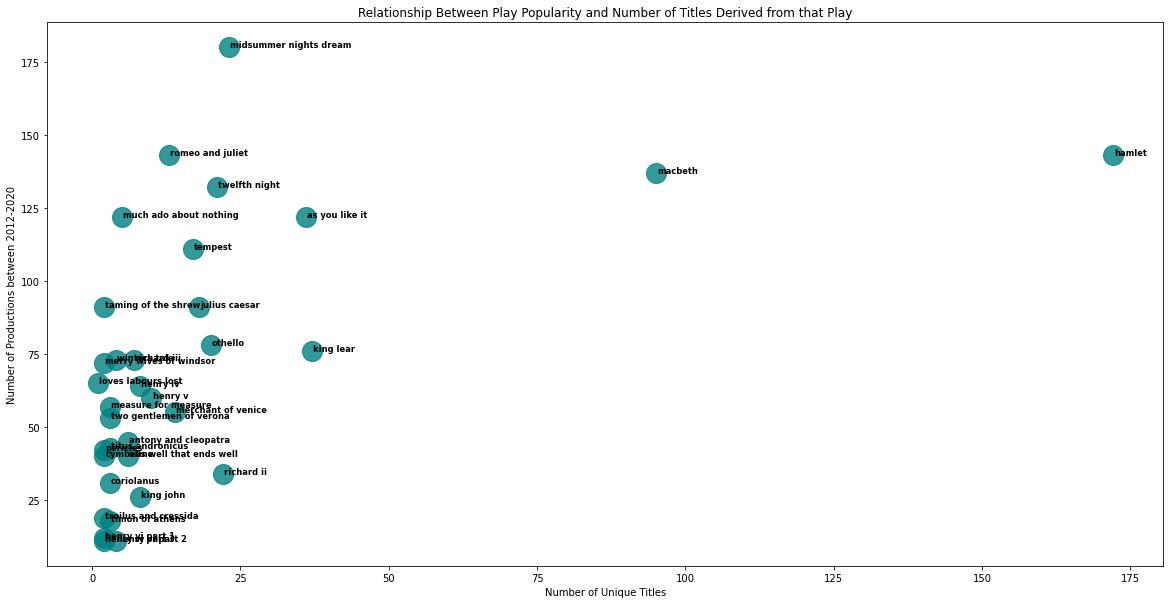

In [26]:
plt.figure(figsize=(20,10))
p1 = sns.regplot(x='Title_Count', y='Productions', data=popularity, fit_reg=False, marker='o', color='teal', scatter_kws={'s':400})
plt.xlabel('Number of Unique Titles')
plt.ylabel('Number of Productions between 2012-2020')
plt.title('Relationship Between Play Popularity and Number of Titles Derived from that Play')
#p1.text(14+0.2, 55, "An annotation", horizontalalignment='left', size='medium', color='black', weight='semibold')

for line in range(0, popularity.shape[0]):
     p1.text(popularity['Title_Count'][line]+0.2, popularity.Productions[line], popularity.Play[line], horizontalalignment='left', size='small', color='black', weight='semibold')

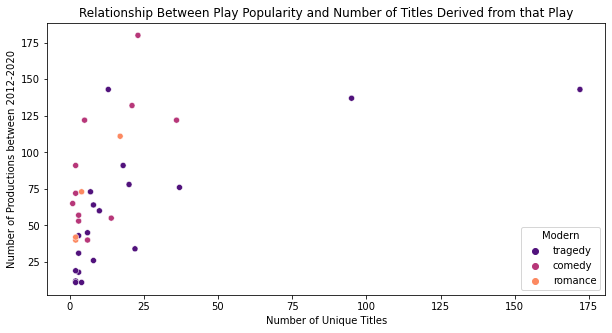

In [28]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='Title_Count', y='Productions', data=popularity, hue='Modern', palette='magma')
plt.xlabel('Number of Unique Titles')
plt.ylabel('Number of Productions between 2012-2020')
plt.title('Relationship Between Play Popularity and Number of Titles Derived from that Play')
plt.show()

Looking at length (word count) of the titles

In [29]:
length_count = []

for title in clean_titles['Title']:
    length = len(title.split())
    length_count.append(length)
    
clean_titles['Title_Length'] = length_count

clean_titles['Title_Length'].describe()

count    616.000000
mean       3.318182
std        1.194592
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       10.000000
Name: Title_Length, dtype: float64

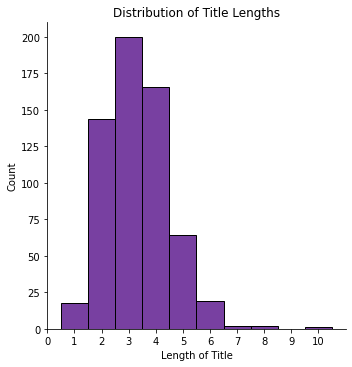

In [30]:
sns.displot(clean_titles, x='Title_Length', color='indigo', discrete=True)
plt.xlabel('Length of Title')
plt.ylabel('Count')
plt.title('Distribution of Title Lengths')
plt.xticks(range(0,11))
plt.show()

In [42]:
print('Number of titles from plays:', clean_titles[clean_titles['Play']!='sonnets']['uniq_id'].count())
print('Number of titles from sonnets:', clean_titles[clean_titles['Play']=='sonnets']['uniq_id'].count())

Number of titles from plays: 590
Number of titles from sonnets: 26


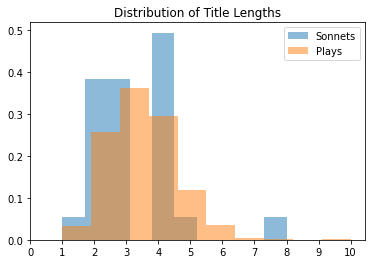

In [48]:
plt.hist(clean_titles[clean_titles['Play']=='sonnets']['Title_Length'], alpha=0.5, density=True, label='Sonnets')
plt.hist(clean_titles[clean_titles['Play']!='sonnets']['Title_Length'], alpha=0.5, density=True, label='Plays')
plt.legend(loc='upper right')
plt.title('Distribution of Title Lengths')
plt.xticks(range(0,11))
plt.show()

In [49]:
titleist = clean_titles.Title.tolist()

titles = ' '.join(titleist)

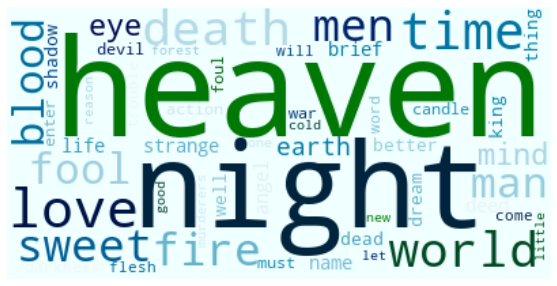

In [50]:
wordcloud = WordCloud(max_font_size=100, max_words=50, colormap='ocean_r', background_color='azure').generate(titles)

# Display the generated image:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [51]:
from PIL import Image

will_mask = np.array(Image.open('../img/william-shakespeare-black-silhouette.png'))
will_mask[0]

array([[255, 255, 255,   0],
       [255, 255, 255,   0],
       [255, 255, 255,   0],
       ...,
       [255, 255, 255,   0],
       [255, 255, 255,   0],
       [255, 255, 255,   0]], dtype=uint8)

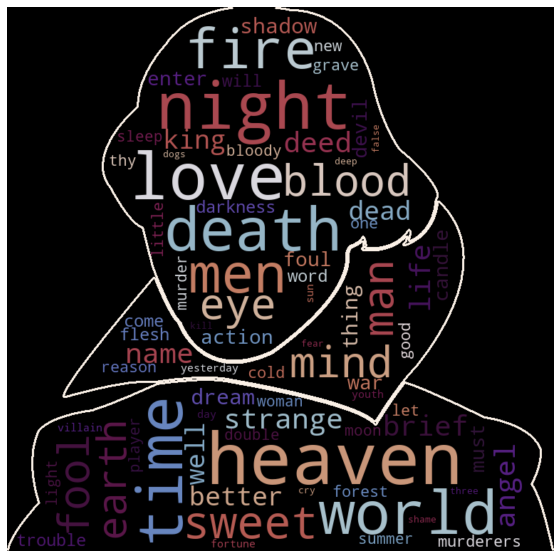

In [52]:
wc = WordCloud(max_font_size=100, max_words=75, colormap='twilight', background_color='black', mask=will_mask, contour_width=2, contour_color='linen')
wc.generate(titles)

# wc.to_file('../img/will_cloud.png')

plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [135]:
clean_titles.sample(5)

,uniq_id,Play,Occurences,Title,Title_Length
442,1143,hamlet,2,act of fear,3
589,1460,hamlet,3,casual slaughters,2
551,1376,hamlet,2,white as snow,3
100,223,king john,1,the fair adventure,3
358,962,tempest,1,brave new world,3


In [53]:
popular.head()

,uniq_id,Play,Occurences,Title
601,308,king lear,82,full circle
237,566,merchant of venice,39,all that glitters
210,500,macbeth,24,all our yesterdays
240,580,merchant of venice,23,the quality of mercy
293,711,othello,19,sweet revenge
